<a href="https://colab.research.google.com/github/cthmayo/hack-aotearoa-2023/blob/main/mdro-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data processing

## Imports

In [1]:
!pip install tableone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
# Import libraries
import numpy as np #1.22.4
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import statsmodels
import tableone
import seaborn as sns
import scipy

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [227]:
import sklearn, xgboost
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, roc_curve

In [258]:
# Python 3.9.16
# using MIMIC-IV 2.2
# module versions asserted for reproducibility
assert np.__version__ == '1.22.4'
assert pd.__version__ == '1.4.4'
assert matplotlib.__version__ == '3.7.1'
assert statsmodels.__version__ == '0.13.5'
assert tableone.__version__ == '0.7.12'
assert sns.__version__ == '0.12.2'
assert sklearn.__version__ == '1.2.2'
assert xgboost.__version__ == '1.7.4'
assert scipy.__version__ == '1.10.1'

In [5]:
def specificity_score(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return tn / (tn+fp)

In [6]:
from tqdm import tqdm
tqdm.pandas()

In [7]:
auth.authenticate_user()

In [8]:
project_id='hack-aotearoa'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [9]:
%%bigquery microbiology

SELECT *
FROM `physionet-data.mimiciv_hosp.microbiologyevents`

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
%%bigquery admissions

SELECT *
FROM `physionet-data.mimiciv_hosp.admissions`

Query is running:   0%|          |

Downloading:   0%|          |

In [11]:
%%bigquery patients

SELECT *
FROM `physionet-data.mimiciv_hosp.patients`

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
%%bigquery vitals

SELECT *
FROM `physionet-data.mimiciv_ed.vitalsign`

Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
%%bigquery ed_stays

SELECT *
FROM `physionet-data.mimiciv_ed.edstays`

Query is running:   0%|          |

Downloading:   0%|          |

## Organising blood cultures

Limit just to blood cultures

In [14]:
df_blood_cultures = microbiology[microbiology['spec_type_desc'] == 'BLOOD CULTURE'].reset_index(drop=True)

NB: note that chartdate is the date that the blood culture was taken

Unit of analysis is admission. Excluding ones that don't have a hadm_id.

In [15]:
df_blood_cultures = df_blood_cultures[~df_blood_cultures['hadm_id'].isna()].reset_index(drop=True)

In [16]:
df_blood_cultures['hadm_id'].value_counts()

27348462    235
20229058    216
29398338    202
24804072    193
23676242    166
           ... 
24074578      1
27604467      1
21358819      1
28056399      1
20767367      1
Name: hadm_id, Length: 71483, dtype: Int64

In [17]:
df_admissions = pd.DataFrame()
df_admissions['hadm_id'] = df_blood_cultures['hadm_id'].value_counts().keys()

## Defining multiresistant organisms

In [18]:
def array_is_just_nones(ar):
  for i in ar:
    if not i is None:
      return False
  return True

In [19]:
def classify_status_of_bug(hadm_id, return_relevant_cultures = False):
  df_admission_cultures = df_blood_cultures[df_blood_cultures['hadm_id'] == hadm_id]
  # just look at cultures taken in the first 24 hours
  df_admission_cultures = df_admission_cultures[(df_admission_cultures['charttime'] >= df_admission_cultures['charttime'].min()) &
                                                (df_admission_cultures['charttime'] <= (df_admission_cultures['charttime'].min() + np.timedelta64(1, 'D')))]
  
  if return_relevant_cultures:
    return df_admission_cultures

  if array_is_just_nones(df_admission_cultures['org_name'].values):
    return 'No growth'
  else:
    resistant_bug_categories = []
    
    for org_name, ab_name, interpretation in zip(df_admission_cultures['org_name'], df_admission_cultures['ab_name'], df_admission_cultures['interpretation']):
      if not org_name is None:
        if org_name == 'STAPH AUREUS COAG +':
          if ab_name in ['OXACILLIN','VANCOMYCIN'] and interpretation == 'R':
            resistant_bug_categories.append('MRSA')
        if 'ENTEROCOCCUS' in org_name:
          if ab_name in ['VANCOMYCIN'] and interpretation == 'R':
            resistant_bug_categories.append('VRE')
        if 'KLEBSIELLA' in org_name or 'PSEUDOMONAS' in org_name or 'ENTEROBACTER' in org_name or 'PROTEUS' in org_name or 'ESCHERICHIA' in org_name or 'SERRATIA' in org_name:
          if ab_name in ['CEFTAZIDIME','MEROPENEM','IMIPENEM'] and interpretation == 'R':
            resistant_bug_categories.append('ESBL')
    # check for MDRO
    return resistant_bug_categories

In [20]:
df_admissions['Status'] = df_admissions['hadm_id'].progress_apply(classify_status_of_bug)

100%|██████████| 71483/71483 [04:27<00:00, 267.52it/s]


In [21]:
def simplify_classification(complex_classification):
  if complex_classification == 'No growth':
    return 'No growth'
  if complex_classification == []:
    return 'Positive culture'
  else:
    return 'Positive culture with MDRO'

In [22]:
df_admissions['Status simplified'] = df_admissions['Status'].apply(simplify_classification)

In [23]:
df_admissions['Status simplified'].value_counts()

No growth                     67315
Positive culture               3673
Positive culture with MDRO      495
Name: Status simplified, dtype: int64

## Adding admission information

Adding admission location, insurance status, marital status, race.

In [24]:
df_admissions['hadm_id']

0        27348462
1        20229058
2        29398338
3        24804072
4        23676242
           ...   
71478    24074578
71479    27604467
71480    21358819
71481    28056399
71482    20767367
Name: hadm_id, Length: 71483, dtype: Int64

In [25]:
admissions_dict = {hadm_id: (subject_id,admission_location,insurance,marital_status,race)  for hadm_id, subject_id,admission_location,insurance,marital_status,race in zip(admissions['hadm_id'], admissions['subject_id'], admissions['admission_location'],admissions['insurance'],admissions['marital_status'],admissions['race'])}

In [26]:
df_admissions['subject_id'] = df_admissions['hadm_id'].apply(lambda x: admissions_dict[x][0])
df_admissions['admission_location'] = df_admissions['hadm_id'].apply(lambda x: admissions_dict[x][1])
df_admissions['insurance'] = df_admissions['hadm_id'].apply(lambda x: admissions_dict[x][2])
df_admissions['marital_status'] = df_admissions['hadm_id'].apply(lambda x: admissions_dict[x][3])
df_admissions['race'] = df_admissions['hadm_id'].apply(lambda x: admissions_dict[x][4])

## Adding patient data

Adding age and gender.

In [27]:
demo_dict = {subject_id: (gender, age) for subject_id, gender, age in zip(patients['subject_id'], patients['gender'] ,patients['anchor_age'])}

In [28]:
df_admissions['gender'] = df_admissions['subject_id'].apply(lambda x: demo_dict[x][0])
df_admissions['age'] = df_admissions['subject_id'].apply(lambda x: demo_dict[x][1])

## Adding lab data

In [29]:
from google.cloud import bigquery

# Create a BigQuery client object
client = bigquery.Client()

# Define your SQL query as a string
query_string = """
    SELECT *
    FROM `physionet-data.mimiciv_hosp.labevents`
    WHERE hadm_id IN ("""+','.join([str(x) for x in df_admissions['hadm_id'].value_counts().keys()])+""")
    """

# Execute the query using the client object
labevents = client.query(query_string).to_dataframe()

Data dictionary for lab items

In [30]:
%%bigquery d_labitems

SELECT *
FROM `physionet-data.mimiciv_hosp.d_labitems`

Query is running:   0%|          |

Downloading:   0%|          |

In [31]:
d_labitems_dict = {itemid: label for itemid, label in zip(d_labitems['itemid'], d_labitems['label'])}

In [32]:
labevents['label'] = labevents['itemid'].apply(lambda x: d_labitems_dict[x])

Choosing a subset of labs as the likely relevant ones

In [33]:
df_relevant_labs = labevents[labevents['label'].isin(['Hemoglobin','White Blood Cells','Platelet Count','Creatinine',
                                                      'Sodium','Potassium','Neutrophils','Lymphocytes','Lactate','Glucose',
                                                      'C-Reactive Protein','Ferritin'])]

In [34]:
del labevents

In [35]:
df_admissions['Culture Time'] = df_admissions['hadm_id'].progress_apply(lambda hadm_id: df_blood_cultures[df_blood_cultures['hadm_id'] == hadm_id]['charttime'].min())

100%|██████████| 71483/71483 [02:07<00:00, 559.48it/s]


In [36]:
blood_culture_time_dict = {hadm_id:culture_time for hadm_id,culture_time in zip(df_admissions['hadm_id'],df_admissions['Culture Time'])}

In [37]:
df_relevant_labs['Culture Time'] = df_relevant_labs['hadm_id'].progress_apply(lambda x: blood_culture_time_dict[x])

100%|██████████| 7023106/7023106 [00:18<00:00, 384556.42it/s]


In [38]:
df_relevant_labs['Culture Time Delta'] = df_relevant_labs['Culture Time'] - df_relevant_labs['charttime']

We are only going to use labs that were taken in the 24 hours before the blood culture was taken (or labs taken concurrently with the blood culture)

In [39]:
df_relevant_labs = df_relevant_labs[(df_relevant_labs['Culture Time Delta'] < np.timedelta64(24,'h')) & (df_relevant_labs['Culture Time Delta'] >= np.timedelta64(0,'h'))]

In [40]:
df_relevant_labs_sorted = df_relevant_labs.sort_values(by='Culture Time Delta', ascending=False)

In [41]:
hadm_and_label_to_value = {}

In [42]:
for hadm_id, label, value in zip(df_relevant_labs_sorted['hadm_id'], df_relevant_labs_sorted['label'], df_relevant_labs_sorted['value']):
  hadm_and_label_to_value[(hadm_id, label)] = value

In the case of multiple labs, we will take the one closest to blood culture time.

In [43]:
def get_closest_lab_value_to_culture(hadm_id, label):
  df_particular_set = df_relevant_labs[(df_relevant_labs['hadm_id'] == hadm_id) & (df_relevant_labs['label'] == label)]
  values = df_particular_set.sort_values(by='Culture Time Delta')['value'].values
  if len(values) > 0:
    return values[0]
  else:
    return np.nan

In [44]:
for test in ['Hemoglobin','White Blood Cells','Platelet Count','Creatinine','Sodium','Potassium','Neutrophils','Lymphocytes','Lactate','Glucose','C-Reactive Protein','Ferritin']:
  try:
    df_admissions[test] = df_admissions['hadm_id'].apply(lambda x: hadm_and_label_to_value[(x, test)] if (x,test) in hadm_and_label_to_value.keys() else np.nan)
  except:
    pass

In [45]:
del df_relevant_labs, df_relevant_labs_sorted

## Adding vitals

In [46]:
stay_to_hadm = {stay:hadm for stay, hadm in zip(ed_stays['stay_id'], ed_stays['hadm_id'])}

In [47]:
vitals['hadm_id'] = vitals['stay_id'].apply(lambda x: stay_to_hadm[x])

In [48]:
df_relevant_vitals = vitals[~vitals['hadm_id'].isna()]

In [49]:
del vitals

In [50]:
df_relevant_vitals = df_relevant_vitals[df_relevant_vitals['hadm_id'].isin(df_admissions['hadm_id'].values)].reset_index(drop=True)

In [51]:
df_relevant_vitals['Culture Time'] = df_relevant_vitals['hadm_id'].progress_apply(lambda x: blood_culture_time_dict[x])

100%|██████████| 192147/192147 [00:00<00:00, 313369.57it/s]


In [52]:
df_relevant_vitals['Culture Time Delta'] = df_relevant_vitals['Culture Time'] - df_relevant_vitals['charttime']

In [53]:
df_relevant_vitals = df_relevant_vitals[(df_relevant_vitals['Culture Time Delta'] < np.timedelta64(90,'m')) & (df_relevant_vitals['Culture Time Delta'] >= np.timedelta64(0,'h'))].reset_index(drop=True)

In [54]:
df_relevant_vitals_sorted = df_relevant_vitals.sort_values(by='Culture Time Delta').reset_index(drop=True)

In [55]:
df_relevant_vitals_sorted['hadm_id'] = df_relevant_vitals_sorted['hadm_id'].astype(np.int64)
df_admissions['hadm_id'] = df_admissions['hadm_id'].astype(np.int64)

In [56]:
hadm_to_obs = {hadm:(temperature,heartrate,resprate,o2sat,sbp,dbp) for hadm,temperature,heartrate,resprate,o2sat,sbp,dbp
               in zip(df_relevant_vitals_sorted['hadm_id'],df_relevant_vitals_sorted['temperature'],df_relevant_vitals_sorted['heartrate'],df_relevant_vitals_sorted['resprate'],
               df_relevant_vitals_sorted['o2sat'],df_relevant_vitals_sorted['sbp'],df_relevant_vitals_sorted['dbp'])}

In [57]:
df_admissions['temperature'] = df_admissions['hadm_id'].apply(lambda x: hadm_to_obs[x][0] if x in hadm_to_obs.keys() else np.nan)
df_admissions['heartrate'] = df_admissions['hadm_id'].apply(lambda x: hadm_to_obs[x][1] if x in hadm_to_obs.keys() else np.nan)
df_admissions['resprate'] = df_admissions['hadm_id'].apply(lambda x: hadm_to_obs[x][2] if x in hadm_to_obs.keys() else np.nan)
df_admissions['o2sat'] = df_admissions['hadm_id'].apply(lambda x: hadm_to_obs[x][3] if x in hadm_to_obs.keys() else np.nan)
df_admissions['sbp'] = df_admissions['hadm_id'].apply(lambda x: hadm_to_obs[x][4] if x in hadm_to_obs.keys() else np.nan)
df_admissions['dbp'] = df_admissions['hadm_id'].apply(lambda x: hadm_to_obs[x][5] if x in hadm_to_obs.keys() else np.nan)

## Previous septic events

In [58]:
df_admissions = df_admissions.sort_values('Culture Time').reset_index(drop=True)

In [59]:
prev_status = []
worst_status_dict = {}
for subject_id, status_simplified in zip(df_admissions['subject_id'],df_admissions['Status simplified']):
  if not subject_id in worst_status_dict.keys():
    prev_status.append(np.nan)
    worst_status_dict[subject_id] = status_simplified
  else:
    prev_status.append(worst_status_dict[subject_id])
    if (worst_status_dict[subject_id] == 'No growth') and ('Positive culture' in status_simplified):
      worst_status_dict[subject_id] = status_simplified
    if (worst_status_dict[subject_id] == 'Positive culture') and ('MDRO' in status_simplified):
      worst_status_dict[subject_id] = status_simplified

In [60]:
df_admissions['Previous events'] = prev_status

## Excluding neutropenic patients

In [61]:
df_admissions['White Blood Cells'] = df_admissions['White Blood Cells'].apply(lambda x: np.nan if x in ['___', None] else float(x))

In [62]:
df_admissions['Neutrophils'] = df_admissions['Neutrophils'].apply(lambda x: np.nan if x in ['___', None] else float(x))
df_admissions['Lymphocytes'] = df_admissions['Lymphocytes'].apply(lambda x: np.nan if x in ['___', None] else float(x))

In [63]:
df_admissions['Neutrophils'] = df_admissions['White Blood Cells'] * df_admissions['Neutrophils'] / 100
df_admissions['Lymphocytes'] = df_admissions['White Blood Cells'] * df_admissions['Lymphocytes'] / 100

Exclude patients with known moderate-severe neutropenia (WCC or neuts < 1)

In [64]:
df_admissions = df_admissions[~(df_admissions['Neutrophils'] < 1) | (df_admissions['White Blood Cells'] < 1)]

In [65]:
df_admissions = df_admissions.reset_index(drop=True)

In [66]:
df_admissions

,hadm_id,Status,Status simplified,subject_id,admission_location,insurance,marital_status,race,gender,age,...,Glucose,C-Reactive Protein,Ferritin,temperature,heartrate,resprate,o2sat,sbp,dbp,Previous events
0,21081215,No growth,No growth,16904137,TRANSFER FROM HOSPITAL,Other,MARRIED,OTHER,M,54,...,___,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20302177,No growth,No growth,12024697,EMERGENCY ROOM,Other,MARRIED,WHITE,M,83,...,119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29343161,No growth,No growth,10540472,PHYSICIAN REFERRAL,Other,SINGLE,WHITE,F,59,...,___,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28453791,No growth,No growth,13201095,TRANSFER FROM HOSPITAL,Medicare,WIDOWED,UNKNOWN,F,88,...,___,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20446666,No growth,No growth,12770182,TRANSFER FROM HOSPITAL,Other,MARRIED,WHITE,M,53,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70728,29642380,No growth,No growth,15338454,PHYSICIAN REFERRAL,Medicare,SINGLE,WHITE,M,67,...,___,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No growth
70729,26783082,No growth,No growth,12844772,PHYSICIAN REFERRAL,Medicare,SINGLE,WHITE,M,58,...,___,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No growth
70730,27172669,No growth,No growth,17601003,PHYSICIAN REFERRAL,Other,SINGLE,WHITE,M,62,...,___,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70731,23311152,No growth,No growth,14648269,INTERNAL TRANSFER TO OR FROM PSYCH,Medicare,SINGLE,WHITE,M,54,...,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA/cleaning

## Overall

In [67]:
colors = sns.color_palette('pastel')[0:5]

In [284]:
df_admissions['Status simplified'].value_counts()

No growth                     66605
Positive culture               3635
Positive culture with MDRO      493
Name: Status simplified, dtype: int64

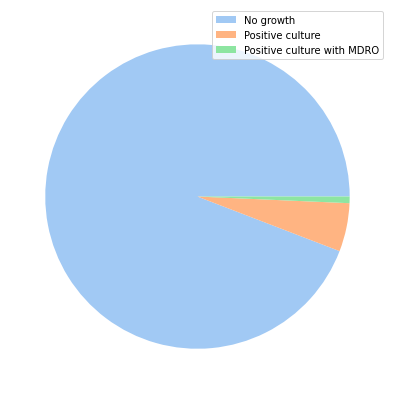

In [68]:
plt.figure(figsize=(7,7))
plt.pie(df_admissions['Status simplified'].value_counts(), colors=colors)
plt.legend(df_admissions['Status simplified'].value_counts().keys())
plt.show()

## Demographics

Admission Location

In [69]:
df_admissions['admission_location'] = df_admissions['admission_location'].apply(lambda x: 'OTHER' if x in ['TRANSFER FROM SKILLED NURSING FACILITY','PROCEDURE SITE',
                                                                     'PACU','INFORMATION NOT AVAILABLE','INTERNAL TRANSFER TO OR FROM PSYCH',
                                                                     'AMBULATORY SURGERY TRANSFER'] else x)

In [70]:
df_admissions['admission_location'].value_counts()

EMERGENCY ROOM            38078
PHYSICIAN REFERRAL        13234
TRANSFER FROM HOSPITAL    11693
CLINIC REFERRAL            2869
OTHER                      2471
WALK-IN/SELF REFERRAL      2388
Name: admission_location, dtype: int64

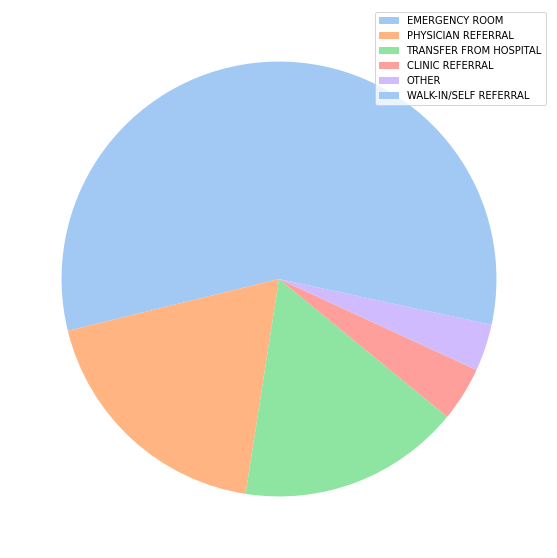

In [71]:
plt.figure(figsize=(10,10))
plt.pie(df_admissions['admission_location'].value_counts(), colors=colors)
plt.legend(df_admissions['admission_location'].value_counts().keys())
plt.show()

Insurance

In [72]:
df_admissions['insurance'].value_counts()

Other       33490
Medicare    31296
Medicaid     5947
Name: insurance, dtype: int64

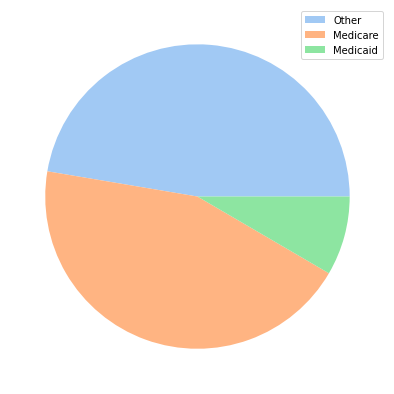

In [73]:
plt.figure(figsize=(7,7))
plt.pie(df_admissions['insurance'].value_counts(), colors=colors)
plt.legend(df_admissions['insurance'].value_counts().keys())
plt.show()

Marital status

In [74]:
df_admissions['marital_status'].value_counts()

MARRIED     31090
SINGLE      23217
WIDOWED      8337
DIVORCED     5480
Name: marital_status, dtype: int64

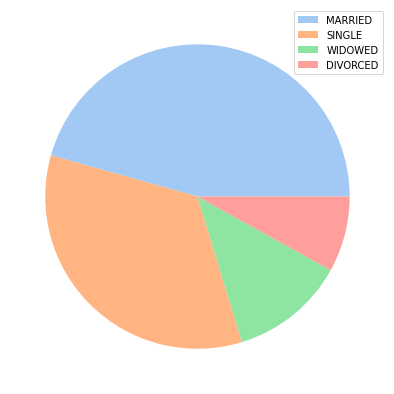

In [75]:
plt.figure(figsize=(7,7))
plt.pie(df_admissions['marital_status'].value_counts(), colors=colors)
plt.legend(df_admissions['marital_status'].value_counts().keys())
plt.show()

Race

In [76]:
def classify_ethnicity(race):
  if 'WHITE' in race:
    return 'White'
  if 'HISPANIC' in race:
    return 'Hispanic'
  if 'BLACK' in race:
    return 'Black'
  if 'ASIAN' in race:
    return 'Asian'
  if 'PORTUGUESE' in race:
    return 'White'
  else:
    return 'Other'

In [77]:
df_admissions['race'] = df_admissions['race'].apply(classify_ethnicity)

In [78]:
df_admissions['race'].value_counts()

White       48586
Black        9824
Other        6497
Hispanic     3500
Asian        2326
Name: race, dtype: int64

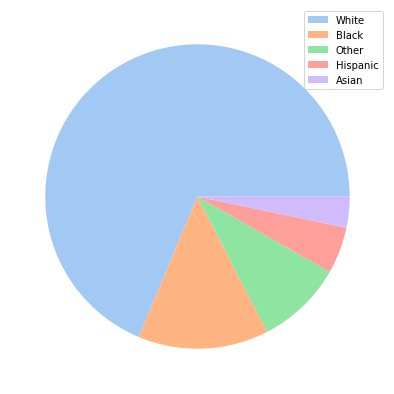

In [79]:
plt.figure(figsize=(7,7))
plt.pie(df_admissions['race'].value_counts(), colors=colors)
plt.legend(df_admissions['race'].value_counts().keys())
plt.show()

Gender

In [80]:
df_admissions['gender'].value_counts()

M    38019
F    32714
Name: gender, dtype: int64

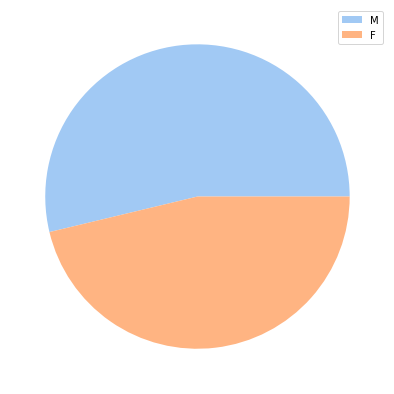

In [81]:
plt.figure(figsize=(7,7))
plt.pie(df_admissions['gender'].value_counts(), colors=colors)
plt.legend(df_admissions['gender'].value_counts().keys())
plt.show()

Age

<Axes: xlabel='age', ylabel='Count'>

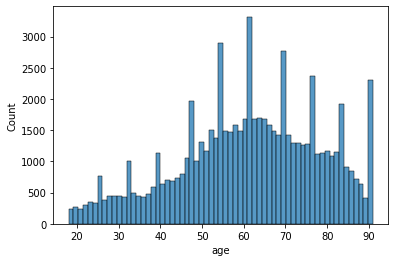

In [82]:
sns.histplot(df_admissions['age'])

Previous events

In [83]:
df_admissions['Previous events'].value_counts()

No growth                     21832
Positive culture               3317
Positive culture with MDRO      661
Name: Previous events, dtype: int64

## Bloods

Hb

In [84]:
df_admissions['Hemoglobin'] = df_admissions['Hemoglobin'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [85]:
df_admissions['Hemoglobin'].isna().value_counts()

False    58221
True     12512
Name: Hemoglobin, dtype: int64

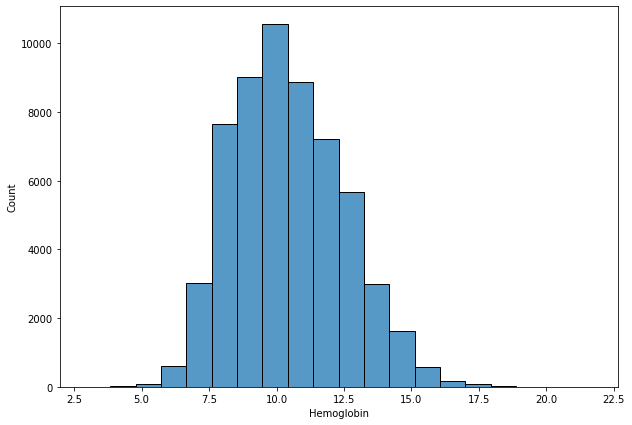

In [86]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='Hemoglobin',bins=20)
plt.show()

WCC

In [87]:
df_admissions['White Blood Cells'] = df_admissions['White Blood Cells'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [88]:
df_admissions['White Blood Cells'].isna().value_counts()

False    56650
True     14083
Name: White Blood Cells, dtype: int64

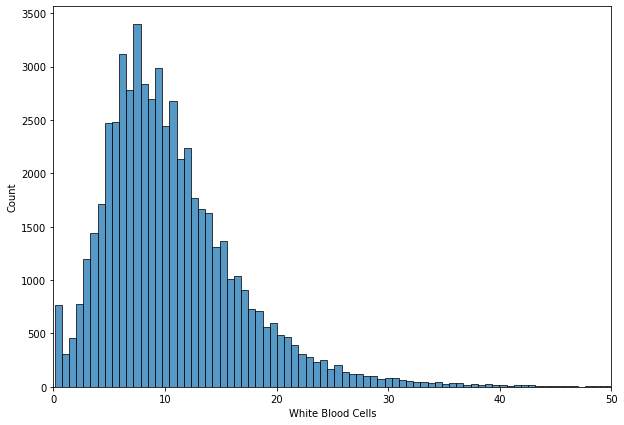

In [89]:
plt.figure(figsize=(10,7))
plt.xlim(0,50)
sns.histplot(df_admissions,x='White Blood Cells',bins=600)
plt.show()

Platelet Count

In [90]:
df_admissions['Platelet Count'] = df_admissions['Platelet Count'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [91]:
df_admissions['Platelet Count'].isna().value_counts()

False    56178
True     14555
Name: Platelet Count, dtype: int64

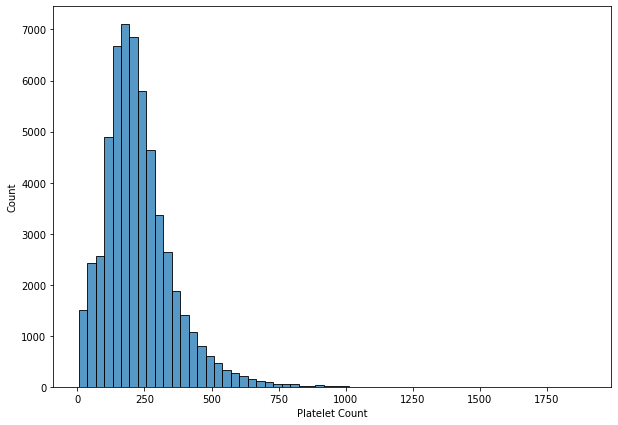

In [92]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='Platelet Count',bins=60)
plt.show()

Cr

In [93]:
df_admissions['Creatinine'] = df_admissions['Creatinine'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [94]:
df_admissions['Creatinine'].isna().value_counts()

False    57459
True     13274
Name: Creatinine, dtype: int64

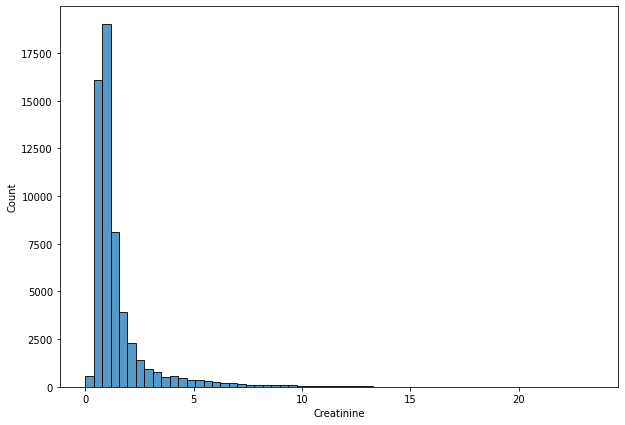

In [95]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='Creatinine',bins=60)
plt.show()

Sodium

In [96]:
df_admissions['Sodium'] = df_admissions['Sodium'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [97]:
df_admissions['Sodium'].isna().value_counts()

False    48663
True     22070
Name: Sodium, dtype: int64

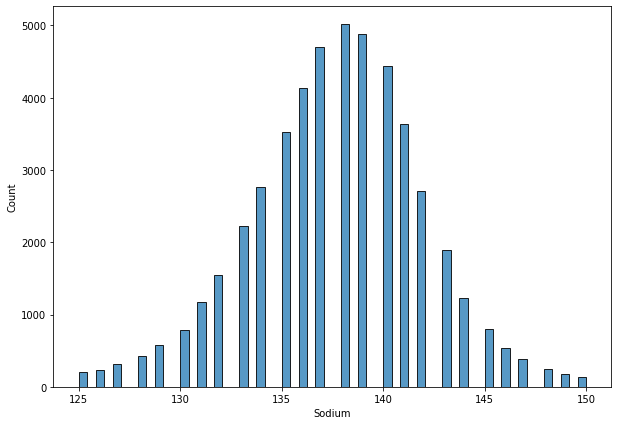

In [98]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='Sodium',bins=60)
plt.show()

K

In [99]:
df_admissions['Potassium'] = df_admissions['Potassium'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [100]:
df_admissions['Potassium'].isna().value_counts()

False    50399
True     20334
Name: Potassium, dtype: int64

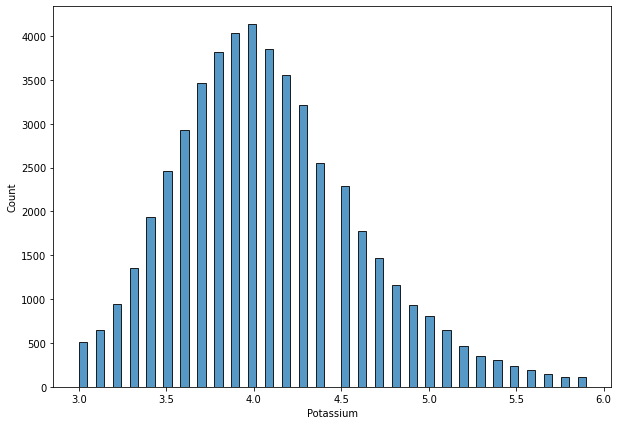

In [101]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='Potassium',bins=60)
plt.show()

Neuts

In [102]:
df_admissions['Neutrophils'].isna().value_counts()

True     49529
False    21204
Name: Neutrophils, dtype: int64

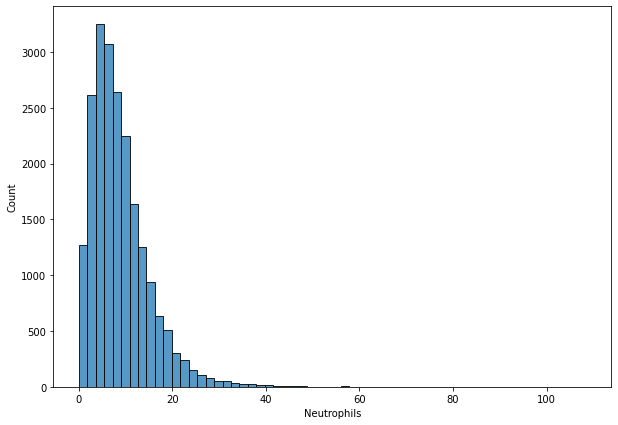

In [103]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='Neutrophils',bins=60)
plt.show()

Lymphocytes

In [104]:
df_admissions['Lymphocytes'].isna().value_counts()

True     47807
False    22926
Name: Lymphocytes, dtype: int64

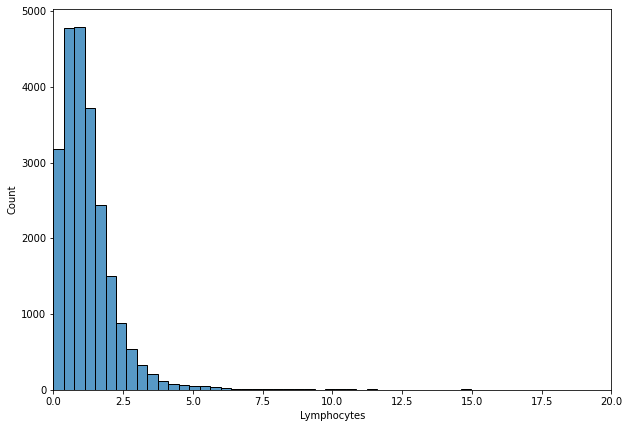

In [105]:
plt.figure(figsize=(10,7))
plt.xlim(0, 20)
sns.histplot(df_admissions,x='Lymphocytes',bins=500)
plt.show()

Lactate

In [106]:
df_admissions['Lactate'] = df_admissions['Lactate'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [107]:
df_admissions['Lactate'].isna().value_counts()

True     59688
False    11045
Name: Lactate, dtype: int64

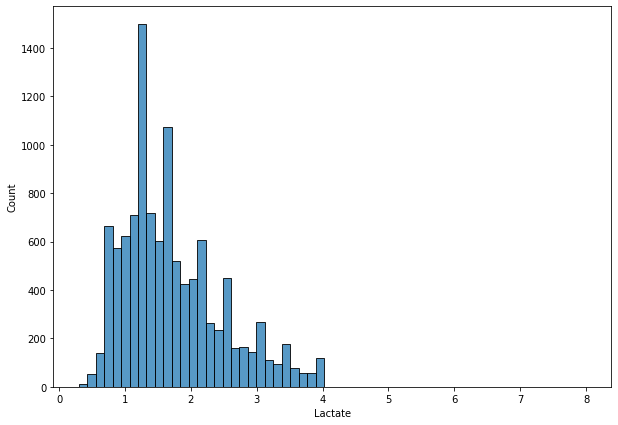

In [108]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='Lactate',bins=60)
plt.show()

Glucose

In [109]:
df_admissions['Glucose'] = df_admissions['Glucose'].apply(lambda x: np.nan if x in ['___','None','NEG','TR','>1000',1000] else x).astype(float)

In [110]:
df_admissions['Glucose'].isna().value_counts()

True     61641
False     9092
Name: Glucose, dtype: int64

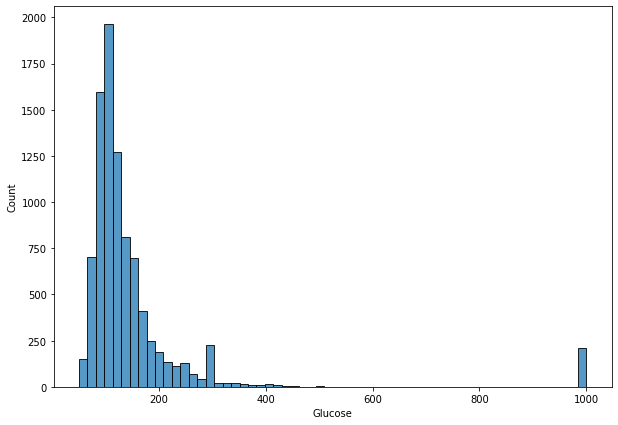

In [111]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='Glucose',bins=60)
plt.show()

C-Reactive Protein

In [112]:
df_admissions['C-Reactive Protein'] = df_admissions['C-Reactive Protein'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [113]:
df_admissions['C-Reactive Protein'].isna().value_counts()

True     69802
False      931
Name: C-Reactive Protein, dtype: int64

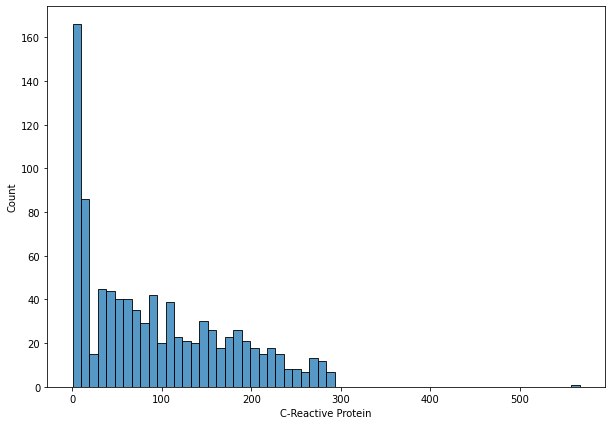

In [114]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='C-Reactive Protein',bins=60)
plt.show()

Ferritin

In [115]:
df_admissions['Ferritin'] = df_admissions['Ferritin'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [116]:
df_admissions['Ferritin'].isna().value_counts()

True     67702
False     3031
Name: Ferritin, dtype: int64

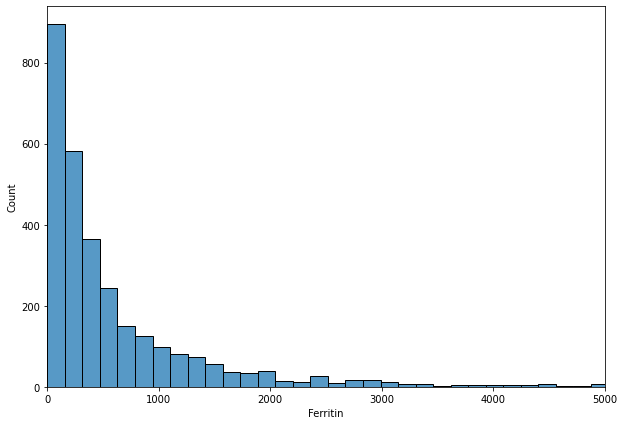

In [117]:
plt.figure(figsize=(10,7))
plt.xlim(0,5000)
sns.histplot(df_admissions,x='Ferritin',bins=600)
plt.show()

## Vitals

Temp

In [118]:
df_admissions['temperature'] = df_admissions['temperature'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [119]:
df_admissions['temperature'] = df_admissions['temperature'].apply(lambda x: (x-32)*5/9 if x > 50 else x)

In [120]:
df_admissions['temperature'].isna().value_counts()

True     69625
False     1108
Name: temperature, dtype: int64

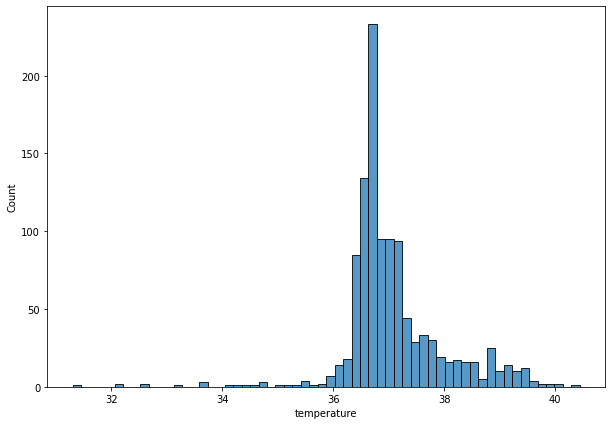

In [121]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='temperature',bins=60)
plt.show()

heartrate

In [122]:
df_admissions['heartrate'] = df_admissions['heartrate'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [123]:
df_admissions['heartrate'].isna().value_counts()

True     68993
False     1740
Name: heartrate, dtype: int64

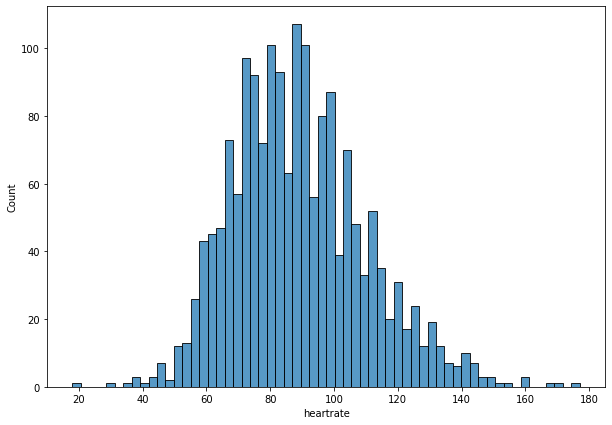

In [124]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='heartrate',bins=60)
plt.show()

resprate

In [125]:
df_admissions['resprate'] = df_admissions['resprate'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [126]:
df_admissions['resprate'].isna().value_counts()

True     69018
False     1715
Name: resprate, dtype: int64

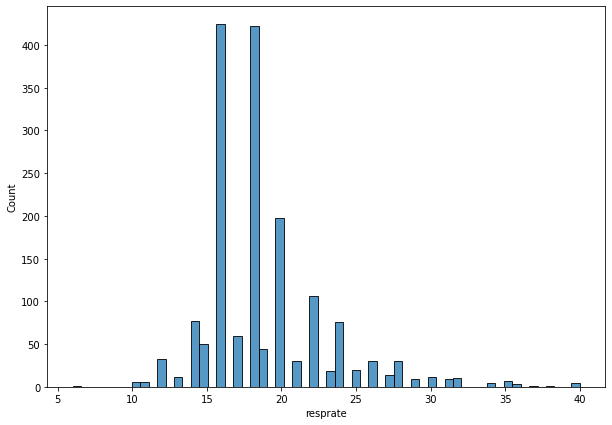

In [127]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='resprate',bins=60)
plt.show()

o2sat

In [128]:
df_admissions['o2sat'] = df_admissions['o2sat'].apply(lambda x: np.nan if x in ['___','None'] else x).astype(float)

In [129]:
df_admissions['o2sat'].isna().value_counts()

True     69071
False     1662
Name: o2sat, dtype: int64

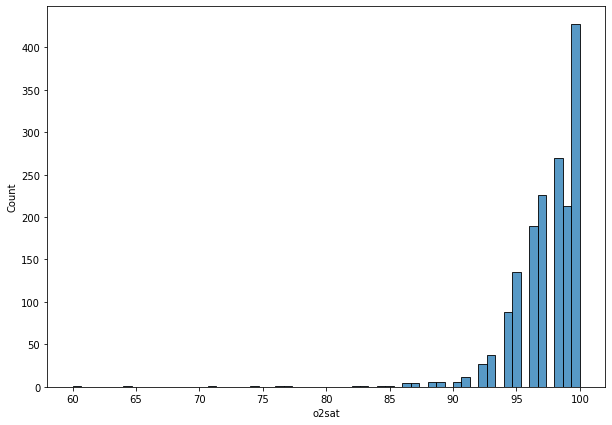

In [130]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='o2sat',bins=60)
plt.show()

sbp

In [131]:
df_admissions['sbp'] = df_admissions['sbp'].apply(lambda x: np.nan if pd.isna(x) or x in ['___','None'] else x).astype(float)

In [132]:
df_admissions['sbp'].isna().value_counts()

True     69014
False     1719
Name: sbp, dtype: int64

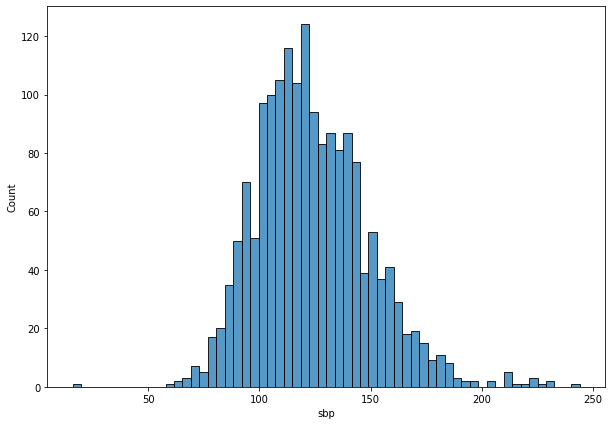

In [133]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='sbp',bins=60)
plt.show()

dbp

In [134]:
df_admissions['dbp'] = df_admissions['dbp'].apply(lambda x: np.nan if pd.isna(x) or x in ['___','None'] or x > 300 else x).astype(float)

In [135]:
df_admissions['dbp'].isna().value_counts()

True     69015
False     1718
Name: dbp, dtype: int64

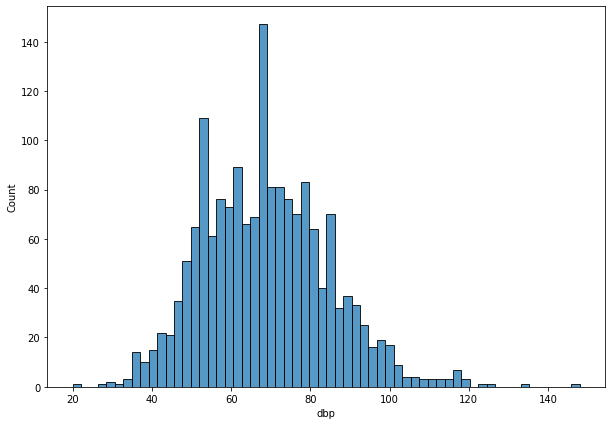

In [136]:
plt.figure(figsize=(10,7))
sns.histplot(df_admissions,x='dbp',bins=60)
plt.show()

## Export

In [137]:
df_admissions.to_csv('mdro_prediction_dataset.csv')

## TableOne

In [138]:
columns = ['admission_location','insurance','marital_status','gender','age','Previous events','Hemoglobin',
           'White Blood Cells','Platelet Count','Creatinine','Sodium',
           'Potassium','Neutrophils','Lymphocytes','Lactate','Glucose',
           'C-Reactive Protein','Ferritin','temperature','heartrate','resprate','o2sat','sbp','dbp']

categorical = ['admission_location','insurance','marital_status','gender','Previous events']

nonnormal = ['age','White Blood Cells','Platelet Count','Creatinine','Neutrophils','Lymphocytes','Lactate',
             'Glucose','C-Reactive Protein','Ferritin','temperature','resprate','o2sat']

groupby = ['Status simplified']

In [139]:
tableone.TableOne(df_admissions,columns=columns,categorical=categorical, groupby=groupby, nonnormal=nonnormal,pval=True)

Grouped by Status simplified                                                                                                   
                                                                                   Missing              Overall            No growth      Positive culture Positive culture with MDRO P-Value
n                                                                                                         70733                66605                  3635                        493        
admission_location, n (%)          CLINIC REFERRAL                                       0           2869 (4.1)           2699 (4.1)             144 (4.0)                   26 (5.3)  <0.001
                                   EMERGENCY ROOM                                                  38078 (53.8)         35975 (54.0)           1902 (52.3)                 201 (40.8)        
                                   OTHER                                                             2471 (3.5)           2313 (3.5)             117 (3.2)                   41 (8.3)        
                                   PHYSICIAN REFERRAL                                              13234 (18.7)         12470 (18.7)            676 (18.6)                  88 (17.8)        
                                   TRANSFER FROM HOSPITAL                                          11693 (16.5)         10915 (16.4)            655 (18.0)                 123 (24.9)        
                                   WALK-IN/SELF REFERRAL                                             2388 (3.4)           2233 (3.4)             141 (3.9)                   14 (2.8)        
insurance, n (%)                   Medicaid                                              0           5947 (8.4)           5550 (8.3)             352 (9.7)                   45 (9.1)   0.024
                                   Medicare                                                        31296 (44.2)         29481 (44.3)           1581 (43.5)                 234 (47.5)        
                                   Other                                                           33490 (47.3)         31574 (47.4)           1702 (46.8)                 214 (43.4)        
marital_status, n (%)              DIVORCED                                           2609           5480 (8.0)           5161 (8.0)             273 (7.8)                   46 (9.5)   0.599
                                   MARRIED                                                         31090 (45.6)         29281 (45.6)           1602 (45.9)                 207 (42.9)        
                                   SINGLE                                                          23217 (34.1)         21838 (34.0)           1213 (34.7)                 166 (34.4)        
                                   WIDOWED                                                          8337 (12.2)          7871 (12.3)            403 (11.5)                  63 (13.1)        
gender, n (%)                      F                                                     0         32714 (46.2)         30952 (46.5)           1556 (42.8)                 206 (41.8)  <0.001
                                   M                                                               38019 (53.8)         35653 (53.5)           2079 (57.2)                 287 (58.2)        
age, median [Q1,Q3]                                                                      0     62.0 [50.0,74.0]     62.0 [50.0,74.0]      62.0 [50.0,73.0]           64.0 [54.0,75.0]   0.009
Previous events, n (%)             No growth                                         44923         21832 (84.6)         20546 (85.2)           1083 (76.2)                 203 (74.6)  <0.001
                                   Positive culture                                                 3317 (12.9)          2981 (12.4)            288 (20.3)                  48 (17.6)        
                                   Positive culture with MDRO           

# Explanatory logistic regression models

## Imputation/one hot encoding

Mean imputation

In [140]:
numerical_columns = pd.DataFrame()

In [141]:
numerical_columns['age'] = df_admissions['age']
numerical_columns['Hemoglobin'] = df_admissions['Hemoglobin'].fillna(df_admissions['Hemoglobin'].mean())
numerical_columns['White Blood Cells'] = df_admissions['White Blood Cells'].fillna(df_admissions['White Blood Cells'].mean())
numerical_columns['Platelet Count'] = df_admissions['Platelet Count'].fillna(df_admissions['Platelet Count'].mean())
numerical_columns['Creatinine'] = df_admissions['Creatinine'].fillna(df_admissions['Creatinine'].mean())
numerical_columns['Sodium'] = df_admissions['Sodium'].fillna(df_admissions['Sodium'].mean())
numerical_columns['Potassium'] = df_admissions['Potassium'].fillna(df_admissions['Potassium'].mean())
numerical_columns['Neutrophils'] = df_admissions['Neutrophils'].fillna(df_admissions['Neutrophils'].mean())
numerical_columns['Lymphocytes'] = df_admissions['Lymphocytes'].fillna(df_admissions['Lymphocytes'].mean())
numerical_columns['Lactate'] = df_admissions['Lactate'].fillna(df_admissions['Lactate'].mean())
numerical_columns['Glucose'] = df_admissions['Glucose'].fillna(df_admissions['Glucose'].mean())
numerical_columns['C-Reactive Protein'] = df_admissions['C-Reactive Protein'].fillna(df_admissions['C-Reactive Protein'].mean())
numerical_columns['Ferritin'] = df_admissions['Ferritin'].fillna(df_admissions['Ferritin'].mean())
numerical_columns['temperature'] = df_admissions['temperature'].fillna(df_admissions['temperature'].mean())
numerical_columns['heartrate'] = df_admissions['heartrate'].fillna(df_admissions['heartrate'].mean())
numerical_columns['resprate'] = df_admissions['resprate'].fillna(df_admissions['resprate'].mean())
numerical_columns['o2sat'] = df_admissions['o2sat'].fillna(df_admissions['o2sat'].mean())
numerical_columns['sbp'] = df_admissions['sbp'].fillna(df_admissions['sbp'].mean())
numerical_columns['dbp'] = df_admissions['dbp'].fillna(df_admissions['dbp'].mean())

In [142]:
categorical_columns = pd.concat(
    [
        pd.get_dummies(df_admissions['admission_location'],prefix='admission_location'),
        pd.get_dummies(df_admissions['insurance'],prefix='insurance'),
        pd.get_dummies(df_admissions['marital_status'],prefix='marital_status'),
        pd.get_dummies(df_admissions['race'],prefix='race'),
        pd.get_dummies(df_admissions['gender'],prefix='gender'),
        pd.get_dummies(df_admissions['Previous events'],prefix='Previous events')
    ], axis=1)

In [143]:
categorical_columns = categorical_columns.drop(['admission_location_EMERGENCY ROOM','insurance_Other','marital_status_MARRIED',
                          'race_White','gender_F'],axis=1)

## Model 1: MRDO vs all others

In [144]:
X_train = pd.concat([categorical_columns,numerical_columns],axis=1)

In [145]:
y_train = (df_admissions['Status simplified'] == 'Positive culture with MDRO').astype(int)

In [146]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.039672
         Iterations 10


In [147]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Status simplified   No. Observations:                70733
Model:                          Logit   Df Residuals:                    70696
Method:                           MLE   Df Model:                           36
Date:                Sat, 18 Mar 2023   Pseudo R-squ.:                 0.04542
Time:                        19:44:25   Log-Likelihood:                -2806.1
converged:                       True   LL-Null:                       -2939.6
Covariance Type:            nonrobust   LLR p-value:                 4.558e-37
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
admission_location_CLINIC REFERRAL             0.3444      0.212      1.624      0.104      -0.071       0.760
admission_location_OTHER                       0.9919      0.175      5.669      0.000       0.649       1.335
admission_location_PHYSICIAN REFERRAL          0.1755      0.130      1.348      0.178      -0.080       0.431
admission_location_TRANSFER FROM HOSPITAL      0.7317      0.119      6.163      0.000       0.499       0.964
admission_location_WALK-IN/SELF REFERRAL       0.0758      0.279      0.272      0.786      -0.471       0.623
insurance_Medicaid                             0.2207      0.171      1.293      0.196      -0.114       0.555
insurance_Medicare                            -0.0727      0.104     -0.699      0.484      -0.276       0.131
marital_status_DIVORCED                        0.3025      0.166      1.826      0.068      -0.022       0.627
marital_status_SINGLE                          0.2825      0.113      2.506      0.012       0.062       0.503
marital_status_WIDOWED                         0.1486      0.155      0.957      0.339      -0.156       0.453
race_Asian                                    -0.1115      0.268     -0.416      0.677      -0.637       0.414
race_Black                                    -0.3697      0.157     -2.360      0.018      -0.677      -0.063
race_Hispanic                                 -0.3732      0.246     -1.518      0.129      -0.855       0.109
race_Other                                    -0.2044      0.177     -1.152      0.249      -0.552       0.143
gender_M                                       0.1920      0.096      1.993      0.046       0.003       0.381
Previous events_No growth                      0.6239      0.103      6.070      0.000       0.422       0.825
Previous events_Positive culture               1.1433      0.166      6.881      0.000       0.818       1.469
Previous events_Positive culture with MDRO     1.8301      0.238      7.702      0.000       1.364       2.296
age                                            0.0114      0.004      3.211      0.001       0.004       0.018
Hemoglobin                                    -0.1076      0.027     -4.053      0.000      -0.160      -0.056
White Blood Cells                              0.0084      0.005      1.852      0.064      -0.000       0.017
Platelet Count                                -0.0002      0.000     -0.546      0.585      -0.001       0.001
Creatinine                                    -0.0216      0.033     -0.650      0.515      -0.087       0.043
Sodium                                        -0.0577      0.012     -4.645      0.000      -0.082      -0.033
Potassium                                     -0.0068      0.103     -0.066      0.947      -0.208       0.195
Neutrophils                                    0.0236      0.011      2.114      0.035       0.002       0.045
Lymphocytes           

MDRO associated with:

1.   Transfers from hospital and other admission locations
2.   Being single rather than married
3.   Being black is protective
4.   Being male
5.   Previous blood cultures, (and more strongly) previous positive blood cultures (and more strongly) positive MDRO blood cultures
6.   Being older
7.   Having a lower Hb
8.   Having a lower Na
9.   Having higher neuts and lower lymphocytes
10.  Having a higher glucose



## Model 2: positive blood culture vs negative blood culture

In [148]:
y_train = (df_admissions['Status simplified'].apply(lambda x: 'Positive culture' in x)).astype(int)

In [149]:
y_train.value_counts()

0    66605
1     4128
Name: Status simplified, dtype: int64

In [150]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.219565
         Iterations 7


In [151]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Status simplified   No. Observations:                70733
Model:                          Logit   Df Residuals:                    70696
Method:                           MLE   Df Model:                           36
Date:                Sat, 18 Mar 2023   Pseudo R-squ.:                 0.01289
Time:                        19:44:26   Log-Likelihood:                -15530.
converged:                       True   LL-Null:                       -15733.
Covariance Type:            nonrobust   LLR p-value:                 4.379e-64
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
admission_location_CLINIC REFERRAL             0.0130      0.083      0.156      0.876      -0.150       0.176
admission_location_OTHER                       0.1231      0.086      1.434      0.152      -0.045       0.291
admission_location_PHYSICIAN REFERRAL          0.0144      0.044      0.326      0.744      -0.072       0.101
admission_location_TRANSFER FROM HOSPITAL      0.1756      0.045      3.917      0.000       0.088       0.263
admission_location_WALK-IN/SELF REFERRAL       0.1353      0.087      1.558      0.119      -0.035       0.306
insurance_Medicaid                             0.1880      0.059      3.190      0.001       0.072       0.304
insurance_Medicare                            -0.0272      0.038     -0.726      0.468      -0.101       0.046
marital_status_DIVORCED                        0.0152      0.063      0.241      0.809      -0.108       0.139
marital_status_SINGLE                          0.0432      0.040      1.084      0.278      -0.035       0.121
marital_status_WIDOWED                         0.0237      0.057      0.414      0.679      -0.089       0.136
race_Asian                                    -0.2003      0.098     -2.044      0.041      -0.392      -0.008
race_Black                                    -0.0491      0.049     -0.992      0.321      -0.146       0.048
race_Hispanic                                 -0.2116      0.081     -2.608      0.009      -0.371      -0.053
race_Other                                     0.0030      0.057      0.052      0.959      -0.109       0.115
gender_M                                       0.1309      0.034      3.835      0.000       0.064       0.198
Previous events_No growth                      0.0705      0.037      1.896      0.058      -0.002       0.143
Previous events_Positive culture               0.6606      0.063     10.460      0.000       0.537       0.784
Previous events_Positive culture with MDRO     0.7037      0.129      5.472      0.000       0.452       0.956
age                                            0.0005      0.001      0.425      0.671      -0.002       0.003
Hemoglobin                                    -0.0336      0.009     -3.690      0.000      -0.052      -0.016
White Blood Cells                              0.0071      0.002      3.926      0.000       0.004       0.011
Platelet Count                                -0.0010      0.000     -6.668      0.000      -0.001      -0.001
Creatinine                                     0.0314      0.010      3.076      0.002       0.011       0.051
Sodium                                        -0.0208      0.005     -4.537      0.000      -0.030      -0.012
Potassium                                     -0.0204      0.037     -0.548      0.584      -0.093       0.053
Neutrophils                                    0.0184      0.005      4.056      0.000       0.010       0.027
Lymphocytes           

Positive blood culture associated with:



1.   Transfers from hospital
2.   Being Asian/Hispanic is protective
3.   Being male
4.   Previous positive cultures
5.   Reduced Hb
6.   Increased WCC
7.   Reduced plt
8.   Increased creatinine
9.   Reduced Na
10.  Increased neutrophils and reduced lymphocytes
11.  Increased lactate
12.  Increased glucose
13.  Increased CRP
14.  Reduced resp rate



Hence uniquely associated with MDRO:

1.   Being single
2.   Being black is protective
3.   Previous MDRO blood cultures
4.   Being older

## Model 3: MRDO positive blood culture vs non-MRDO positive blood culture

In [152]:
y_train = (df_admissions['Status simplified'] == 'Positive culture with MDRO').astype(int)

In [153]:
y_train = y_train[~(df_admissions['Status simplified'] == 'No growth')].reset_index(drop=True)

In [154]:
X_train = X_train[~(df_admissions['Status simplified'] == 'No growth')].reset_index(drop=True)

In [155]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.345018
         Iterations 8


In [156]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Status simplified   No. Observations:                 4128
Model:                          Logit   Df Residuals:                     4091
Method:                           MLE   Df Model:                           36
Date:                Sat, 18 Mar 2023   Pseudo R-squ.:                 0.05677
Time:                        19:44:26   Log-Likelihood:                -1424.2
converged:                       True   LL-Null:                       -1510.0
Covariance Type:            nonrobust   LLR p-value:                 1.503e-19
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
admission_location_CLINIC REFERRAL             0.3527      0.232      1.521      0.128      -0.102       0.807
admission_location_OTHER                       1.0953      0.204      5.363      0.000       0.695       1.496
admission_location_PHYSICIAN REFERRAL          0.1380      0.140      0.985      0.325      -0.137       0.413
admission_location_TRANSFER FROM HOSPITAL      0.6602      0.130      5.084      0.000       0.406       0.915
admission_location_WALK-IN/SELF REFERRAL      -0.0933      0.296     -0.315      0.753      -0.674       0.488
insurance_Medicaid                             0.0305      0.186      0.164      0.870      -0.333       0.394
insurance_Medicare                            -0.0401      0.112     -0.358      0.720      -0.260       0.179
marital_status_DIVORCED                        0.2938      0.183      1.606      0.108      -0.065       0.652
marital_status_SINGLE                          0.3141      0.124      2.535      0.011       0.071       0.557
marital_status_WIDOWED                         0.1743      0.169      1.034      0.301      -0.156       0.505
race_Asian                                     0.1097      0.293      0.374      0.708      -0.465       0.684
race_Black                                    -0.4208      0.168     -2.505      0.012      -0.750      -0.092
race_Hispanic                                 -0.2567      0.267     -0.961      0.337      -0.780       0.267
race_Other                                    -0.1879      0.189     -0.992      0.321      -0.559       0.183
gender_M                                       0.1108      0.104      1.067      0.286      -0.093       0.314
Previous events_No growth                      0.6668      0.111      5.986      0.000       0.448       0.885
Previous events_Positive culture               0.6546      0.182      3.597      0.000       0.298       1.011
Previous events_Positive culture with MDRO     1.4751      0.280      5.265      0.000       0.926       2.024
age                                            0.0130      0.004      3.374      0.001       0.005       0.021
Hemoglobin                                    -0.1066      0.030     -3.540      0.000      -0.166      -0.048
White Blood Cells                              0.0029      0.008      0.361      0.718      -0.013       0.019
Platelet Count                                 0.0008      0.000      1.799      0.072   -7.01e-05       0.002
Creatinine                                    -0.0436      0.036     -1.205      0.228      -0.115       0.027
Sodium                                        -0.0447      0.013     -3.353      0.001      -0.071      -0.019
Potassium                                      0.0249      0.113      0.220      0.826      -0.197       0.247
Neutrophils                                    0.0027      0.015      0.186      0.853      -0.026       0.032
Lymphocytes           

Associations specifically with MDRO:

1.   Admitted from hospital/other
2.   Being single
3.   Being black is protective
4.   Previous blood cultures (and then increasingly) previous positive blood cultures (and then increasingly) previous MDRO positive blood cultures
5.   Being older
6.   Lower Hb
7.   Lower Na

# Predictive models

Aim will be to maximise AUC for prediction of MDRO

## Split test/train

Use GroupShuffleSplit to avoid splitting patients between train and test set!

In [157]:
gss = GroupShuffleSplit(n_splits=1,random_state=42,train_size=0.8)
train_idx, test_idx = next(gss.split(df_admissions,groups=df_admissions['subject_id']))

In [158]:
df_train = df_admissions.iloc[train_idx]

In [159]:
df_test = df_admissions.iloc[test_idx]

## Preprocessing for ML

In [160]:
df_train.columns

Index(['hadm_id', 'Status', 'Status simplified', 'subject_id',
       'admission_location', 'insurance', 'marital_status', 'race', 'gender',
       'age', 'Culture Time', 'Hemoglobin', 'White Blood Cells',
       'Platelet Count', 'Creatinine', 'Sodium', 'Potassium', 'Neutrophils',
       'Lymphocytes', 'Lactate', 'Glucose', 'C-Reactive Protein', 'Ferritin',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp',
       'Previous events'],
      dtype='object')

In [161]:
enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

In [162]:
categorical_columns = enc.fit_transform(df_train[['admission_location', 'insurance', 'marital_status', 'race', 'gender','Previous events']])

In [163]:
scaler = StandardScaler()

In [164]:
numeric_columns = scaler.fit_transform(df_train[['Hemoglobin', 'White Blood Cells',
       'Platelet Count', 'Creatinine', 'Sodium', 'Potassium', 'Neutrophils',
       'Lymphocytes', 'Lactate', 'Glucose', 'C-Reactive Protein', 'Ferritin',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']])

In [165]:
imputer = SimpleImputer()

In [166]:
numeric_columns = imputer.fit_transform(numeric_columns)

In [167]:
X_train_processed = np.concatenate([numeric_columns,categorical_columns],axis=1)

In [168]:
y_train = (df_train['Status simplified'] == 'Positive culture with MDRO').astype(int)

And do the same to the test set...

In [169]:
categorical_columns_test = enc.transform(df_test[['admission_location', 'insurance', 'marital_status', 'race', 'gender','Previous events']])
numeric_columns_test = scaler.transform(df_test[['Hemoglobin', 'White Blood Cells',
       'Platelet Count', 'Creatinine', 'Sodium', 'Potassium', 'Neutrophils',
       'Lymphocytes', 'Lactate', 'Glucose', 'C-Reactive Protein', 'Ferritin',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']])
numeric_columns_test = imputer.fit_transform(numeric_columns_test)
X_test_processed = np.concatenate([numeric_columns_test,categorical_columns_test],axis=1)

In [170]:
y_test = (df_test['Status simplified'] == 'Positive culture with MDRO').astype(int)

In [171]:
X_train_processed.shape

(56519, 43)

## Trialling models

In [280]:
def evaluate_model(model):
  print('Fitting model...')
  model.fit(X_train_processed,y_train)
  print('Evaluating model...')
  y_train_pred = model.predict(X_train_processed)
  y_train_pred_proba = model.predict_proba(X_train_processed)
  y_test_pred = model.predict(X_test_processed)
  y_test_pred_proba = model.predict_proba(X_test_processed)

  print('\nTrain metrics:')
  print('ROC AUC:',roc_auc_score(y_train,y_train_pred_proba[:,1]))
  print('Accuracy:',accuracy_score(y_train,y_train_pred))
  print('Sensitivity/Recall:',recall_score(y_train,y_train_pred))
  print('Specificity:',specificity_score(y_train,y_train_pred))

  print('\nTest metrics:')
  print('ROC AUC:',roc_auc_score(y_test,y_test_pred_proba[:,1]))
  print('Accuracy:',accuracy_score(y_test,y_test_pred))
  print('Sensitivity/Recall:',recall_score(y_test,y_test_pred))
  print('Specificity:',specificity_score(y_test,y_test_pred))

  fpr, tpr, _ = roc_curve(y_test,  y_test_pred_proba[:,1])
  plt.plot(fpr,tpr)
  plt.plot(fpr,fpr)
  plt.show()

Log reg

In [237]:
log_reg = LogisticRegression(random_state=42, class_weight='balanced')

Fitting model...
Evaluating model...

Train metrics:
ROC AUC: 0.7040398353199327
Accuracy: 0.6623259434880305
Sensitivity/Recall: 0.628140703517588
Specificity: 0.6625683790381497

Test metrics:
ROC AUC: 0.6876713350058339
Accuracy: 0.7032503165892782
Sensitivity/Recall: 0.5368421052631579
Specificity: 0.7043699978752036


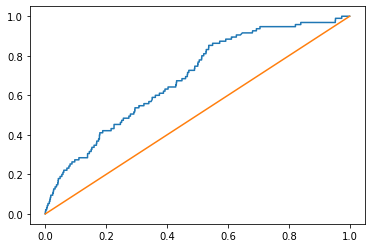

In [281]:
evaluate_model(log_reg)

Random forests

In [239]:
forest_clf = RandomForestClassifier(random_state = 42, class_weight='balanced', max_depth=3)

Fitting model...
Evaluating model...

Train metrics:
ROC AUC: 0.7407697868183061
Accuracy: 0.7145738601178365
Sensitivity/Recall: 0.6180904522613065
Specificity: 0.7152581030273872

Test metrics:
ROC AUC: 0.7033970647988339
Accuracy: 0.764176164345012
Sensitivity/Recall: 0.5157894736842106
Specificity: 0.7658474396203697


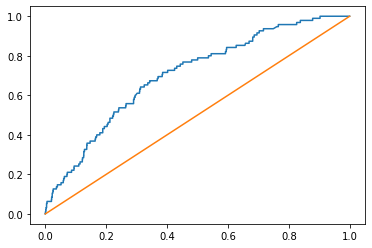

In [282]:
evaluate_model(forest_clf)

XGBoost

In [241]:
xgb_clf = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=1, objective='binary:logistic',scale_pos_weight=141)

Fitting model...
Evaluating model...

Train metrics:
ROC AUC: 0.723853112965981
Accuracy: 0.6033369309435765
Sensitivity/Recall: 0.7311557788944724
Specificity: 0.6024304627501292

Test metrics:
ROC AUC: 0.6936401489594091
Accuracy: 0.5958913747009991
Sensitivity/Recall: 0.7368421052631579
Specificity: 0.5949429846306395


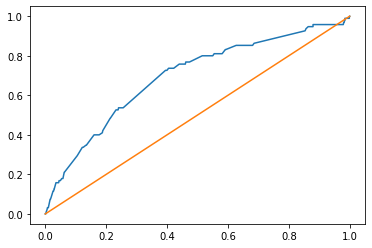

In [283]:
evaluate_model(xgb_clf)

# Post-hoc analyses

Attempting to explain why being black is protective -- do they get less blood cultures?

In [247]:
race_dict = {subject_id:race for subject_id,race in zip(admissions['subject_id'],admissions['race'])}

In [248]:
df_race_post_hoc = pd.DataFrame()
df_race_post_hoc['subject_id'] = df_blood_cultures['subject_id'].value_counts().keys()
df_race_post_hoc['blood culture count'] = df_blood_cultures['subject_id'].value_counts().values
df_race_post_hoc['race'] = df_race_post_hoc['subject_id'].apply(lambda x: race_dict[x])

In [252]:
df_race_post_hoc['race'] = df_race_post_hoc['race'].apply(classify_ethnicity)

In [274]:
np.mean(df_race_post_hoc[df_race_post_hoc['race'] != 'Black']['blood culture count'].values)

7.014690372156094

In [275]:
np.mean(df_race_post_hoc[df_race_post_hoc['race'] == 'Black']['blood culture count'].values)

7.862012094557449

Black people get more blood cultures on average.

In [278]:
df_admissions['race'].value_counts(normalize=True)

White       0.686893
Black       0.138888
Other       0.091852
Hispanic    0.049482
Asian       0.032884
Name: race, dtype: float64